This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/humanoids.html).  I recommend having both windows open, side-by-side!


In [1]:
from functools import partial

import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AddUnitQuaternionConstraintOnPlant,
    AutoDiffXd,
    DiagramBuilder,
    DiscreteTimeLinearQuadraticRegulator,
    ExtractGradient,
    ExtractValue,
    InitializeAutoDiff,
    JacobianWrtVariable,
    JointIndex,
    MathematicalProgram,
    MeshcatVisualizer,
    MultibodyPlant,
    OrientationConstraint,
    Parser,
    PidController,
    PiecewisePolynomial,
    PositionConstraint,
    RigidTransform,
    RotationMatrix,
    Simulator,
    SnoptSolver,
    Solve,
    StartMeshcat,
    eq,
    namedview,
    DirectCollocation,
    PiecewisePolynomial,
    TrajectorySource,
    MultibodyPositionToGeometryPose,

)

from underactuated import ConfigureParser, running_as_notebook



import math
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    LeafSystem,
    LinearSystem,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    Parser,
    LogVectorOutput,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    SymbolicVectorSystem,
    Variable,
    WrapToSystem,
    FrameId
)
from pydrake.common import FindResourceOrThrow

from pydrake.all import MultibodyPlant, RevoluteJoint, RigidTransform, UnitInertia, RigidBody
from pydrake.multibody.tree import SpatialInertia


from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,

    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.geometry import Cylinder

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://0561bb78-2b86-4280-965f-ef37e93411a8.deepnoteproject.com/7001/


In [3]:
rod_link = """ 
    <link name="rod0">

        <inertial>
        <origin xyz="0 0 -1/2" />
        <mass value=".225" />
        </inertial>

    <!-- Visual Component -->

        <visual>
        <origin xyz="0 0 0.5" rpy="0 0 0" />
        <geometry>
            <cylinder length="1.0" radius=".01" />
        </geometry>
        <material>
            <color rgba="1 0 0 1" />
        </material>
        </visual>
        <collision>
            <origin xyz="0 0 0.5" rpy="0 0 0" />
            <geometry>
                <cylinder length="1.0" radius=".01" />
            </geometry>
        </collision>

    </link>
    """

base_link = """<link name="base_link">
    <inertial>
      <mass value="0.775"/>
      <origin xyz="0 0 0"/>
      <inertia ixx="0.0015" ixy="0.0" ixz="0.0" iyy="0.0025" iyz="0.0" izz="0.0035"/>
    </inertial>
    <visual>
      <origin rpy="1.570796 0 0" xyz="0 0 0"/>
      <geometry>
        <mesh filename="package://drake_models/skydio_2/skydio_2_1000_poly.obj" scale=".00254"/>
      </geometry>
    </visual>
    <collision>
      <origin rpy="0 0 0" xyz="0 0 0"/>
      <geometry>
        <box size=".36 .4 .06"/>
      </geometry>
    </collision>
</link>"""

r_joint = """
  <joint name="theta" type="revolute">
    <parent link="base_link" />
    <child link="rod0" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
    <limit lower="0" upper="6.28318530718" />
  </joint>
"""

quadrotor_urdf = f"""<?xml version="1.0"?>
<robot name="quadrotor">
  {base_link}
  {rod_link}
  {r_joint}
</robot>"""

In [4]:
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    BodyIndex
)
import pydrake.math
# from pydrake.math import SpatialInertia
from pydrake.examples import QuadrotorPlant

from underactuated.scenarios import AddFloatingRpyJoint


def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    drone, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(drone)
    ConfigureParser(parser)
    (model_instance, ) = parser.AddModelsFromString(quadrotor_urdf, "urdf")
    # scene_graph = builder.AddSystem(SceneGraph())
    print(builder)
    # AddMultiBodyPlantToBuilder(
    #      builder, drone.get_output_port(), scene_graph
    #  )
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        drone,
        drone.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )

    drone.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = drone.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    type(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        drone.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        drone.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(drone.get_state_output_port(),"outputport")

    # # Edited here
    # diagram_context = diagram.CreateDefaultContext()
    # g = 9.81 # m/s^2
    # mass = 1
    # weight = mass*g
    # Q = np.diag([10, 10, 10, 1, 1, 1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01])  # state cost matrix
    # R = np.diag([1, 1, 1, 1])  # input cost matrix
    # diagram.get_input_port().FixValue(diagram_context,[weight/4,weight/4,weight/4,weight/4])
    # diagram_context.SetContinuousState([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    # controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)



    # builder.AddNamedSystem("lqr", controller)

    # print("drone input port size:", drone.get_input_port(0).size())
    # print("drone output port size:", drone.get_output_port(0).size())
    # print("controller input port size:", controller.get_input_port(0).size())
    # print("controller output port size:", controller.get_output_port(0).size())


    # builder.Connect(drone.get_state_output_port(), controller.get_input_port(0))
    # builder.Connect(controller.get_output_port(0),
    #             drone.get_actuation_input_port())


    # meshcat.Delete()
    # visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # visualizer.set_name("visualizer")

    return builder.Build(), drone, parser, builder, scene_graph
    #return builder.Build(), plant



# # This test demonstrates that the MultibodyPlant version has identical dynamics
# # to the QuadrotorPlant version (except that the state variables are permuted).
# # TODO(russt): Move this to Drake as a unit test.
# def MultibodyQuadrotorExample():
#     mbp_plant, mbp = MakeMultibodyQuadrotor()

#     hand_derived_plant = QuadrotorPlant()

#     # Compare the dynamics at a handful of states.
#     mbp_plant_context = mbp_plant.CreateDefaultContext()
#     mbp_context = mbp.GetMyContextFromRoot(mbp_plant_context)
#     hand_derived_context = hand_derived_plant.CreateDefaultContext()

#     # Permute mbp <=> hand_derived states.
#     P = np.array(
#         [
#             [1, 0, 0, 0, 0, 0],
#             [0, 1, 0, 0, 0, 0],
#             [0, 0, 1, 0, 0, 0],
#             [0, 0, 0, 0, 0, 1],
#             [0, 0, 0, 0, 1, 0],
#             [0, 0, 0, 1, 0, 0],
#         ]
#     )
#     PP = np.block([[P, np.zeros((6, 6))], [np.zeros((6, 6)), P]])

#     rng = np.random.default_rng(seed=1037)
#     for i in range(5):
#         u = rng.random((4,))
#         mbp_x = rng.random((12,)) #25
#         mbp_plant.get_input_port().FixValue(mbp_plant_context, u)
#         mbp_context.SetContinuousState(mbp_x)
#         mbp_xdot = mbp_plant.EvalTimeDerivatives(
#             mbp_plant_context
#         ).CopyToVector()

#         hand_derived_x = PP @ mbp_x
#         hand_derived_plant.get_input_port().FixValue(hand_derived_context, u)
#         hand_derived_context.SetContinuousState(hand_derived_x)
#         hand_derived_xdot = (
#             PP
#             @ hand_derived_plant.EvalTimeDerivatives(
#                 hand_derived_context
#             ).CopyToVector()
#         )

#         assert np.allclose(
#             mbp_xdot, hand_derived_xdot
#         ), f"\nmbp\t\t = {mbp_xdot}\nhand_derived\t = {hand_derived_xdot}"


# MakeMultibodyQuadrotor()
(drone_diagram, drone, parser, builder, scene_graph)=MakeMultibodyQuadrotor()
#(drone_diagram,drone, parser, builder)=MakeMultibodyQuadrotor()

context=drone_diagram.CreateDefaultContext()
drone_diagram.ForcedPublish(context)


# # From here
# if diagram:
#     diagram_context = diagram.CreateDefaultContext()
#     g = 9.81 # m/s^2
#     mass = 1
#     weight = mass*g
#     Q = np.diag([10, 10, 10, 1, 1, 1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01])  # state cost matrix
#     R = np.diag([1, 1, 1, 1])  # input cost matrix
#     diagram.get_input_port().FixValue(diagram_context,[weight/4,weight/4,weight/4,weight/4])
#     diagram_context.SetContinuousState([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#     controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)

#     builder.AddNamedSystem("lqr", controller)

#     builder.Connect(drone.get_state_output_port(), controller.get_input_port(0))
#     builder.Connect(controller.get_output_port(0),
#                 drone.get_actuation_input_port())


#     meshcat.Delete()
#     visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
#     visualizer.set_name("visualizer")



# Get the mass information for the base_link
base_link = drone.GetBodyByName("base_link")
base_link_mass = base_link.default_mass()
print(f"base_link mass: {base_link_mass}")

# Get the mass information for the rod0 link
rod0_link = drone.GetBodyByName("rod0")
rod0_link_mass = rod0_link.default_mass()
print(f"rod0 link mass: {rod0_link_mass}")

PositionView = namedview(
        "States",
        drone.GetStateNames(
            drone.GetModelInstanceByName("quadrotor")))

# Get the state names from the named view
state_names = PositionView._fields

# Print the state names
print("State names: ", state_names)

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/611246c443152946e9dcc901b4f956d89a439a61.tar.gz
base_link mass: 0.775
rod0 link mass: 0.225
State names:  ('x_x', 'y_x', 'z_x', 'rz_q', 'ry_q', 'rx_q', 'theta_q', 'x_v', 'y_v', 'z_v', 'rz_w', 'ry_w', 'rx_w', 'theta_w')


### LQR execution

In [22]:
#def lqrtosys():
builder = DiagramBuilder()
diagram, drone,_, _,_ = MakeMultibodyQuadrotor()
qplantwpend = builder.AddSystem(diagram)
def lqrc(qplantwpend):
    diagram = qplantwpend
    diagram_context = diagram.CreateDefaultContext()
    g = 9.81 # m/s^2
    mass = 1
    weight = mass*g
    Q = np.diag([10,10,10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1])  # state cost matrix
    R = np.diag([1, 1, 1, 1])  # input cost matrix
    diagram.get_input_port().FixValue(diagram_context,[weight/4,weight/4,weight/4,weight/4])
    diagram_context.SetContinuousState([0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)

    return controller

tempvar = lqrc(qplantwpend)
controller = builder.AddSystem(tempvar)
builder.Connect(qplantwpend.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
            qplantwpend.get_input_port(0))

diagram = builder.Build()

#instantiate a simulator
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(True) # makes sim faster
simulator.set_target_realtime_rate(1.0)

context = simulator.get_mutable_context()
context.SetTime(0.0)
context.SetContinuousState([0.5,0.5,0.5,0,0,0,3*(np.pi)/4,0,0,0,0,0,0,0])
simulator.Initialize()
simulator.AdvanceTo(10)

# simulator.get_mutable_integrator().set_fixed_step_mode(True)

# # start recording the video for the animation of the simulation
# visualizer = diagram.GetSubsystemByName("visualizer")
# visualizer.StartRecording(False)

context = qplantwpend.CreateDefaultContext()
qplantwpend.ForcedPublish(context)



# V MPC 

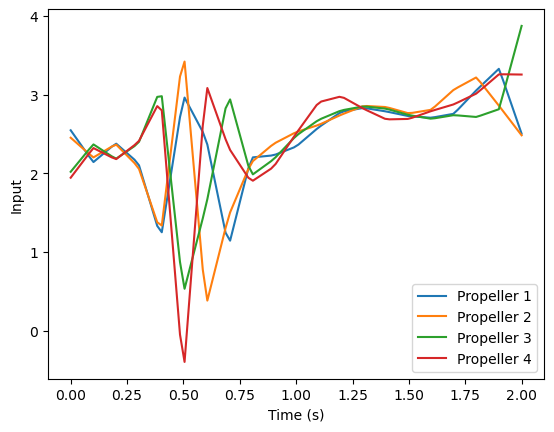

None

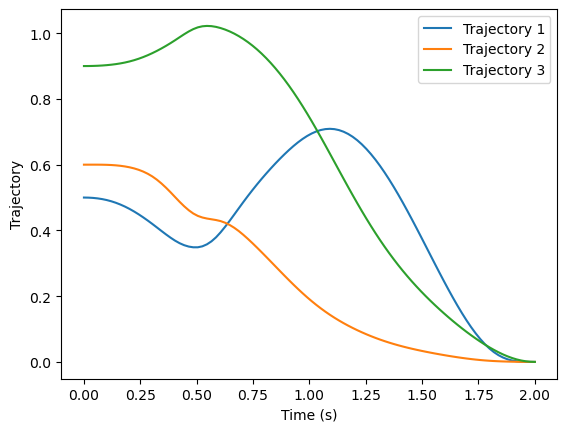

None

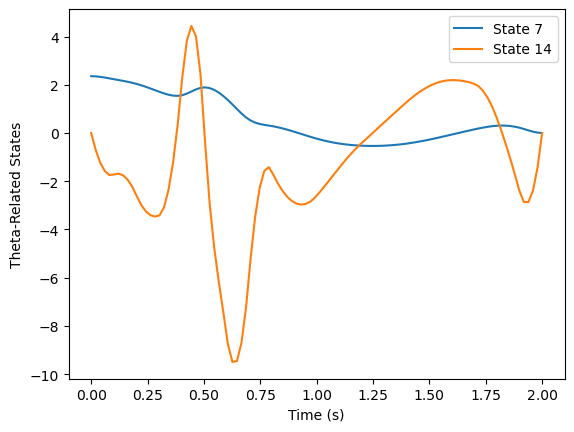

None

In [29]:
# THIS WORKS AND FINDS A SOLN W DIRECT COLLOCATION
_, _,_, _, scene_graph = MakeMultibodyQuadrotor()
def dircol_mpc_drone(scene_graph):
    builder = DiagramBuilder()
    diagram, drone,_, _, _ = MakeMultibodyQuadrotor()
    qplantwpend = builder.AddSystem(diagram)
    diagram = qplantwpend
    diagram_context = diagram.CreateDefaultContext()

    g = 9.81 # m/s^2
    mass = 1
    weight = mass*g
    dircol = DirectCollocation(
        diagram,
        diagram_context,
        num_time_samples=21,
        minimum_timestep=0.1,
        maximum_timestep=0.4,
        input_port_index=diagram.get_input_port().get_index(),
    )
    prog = dircol.prog()
    dircol.AddEqualTimeIntervalsConstraints()
    initial_state = np.array([0.5,0.6,0.9,0,0,0,3*(np.pi)/4,0,0,0,0,0,0,0])
    prog.AddBoundingBoxConstraint(
        initial_state, initial_state, dircol.initial_state()
    )

    final_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    prog.AddBoundingBoxConstraint(
        final_state, final_state, dircol.final_state()
    )
    R = 10  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R * (u[0]**2 + u[1]**2 + u[2]**2 + u[3]**2)) #Penalizing all four input propellers
    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((initial_state, final_state))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()
  
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(
        u_trajectory.start_time(), u_trajectory.end_time(), 100
    )

    u_lookup = [];
    for t in times:
        u_lookup.append(np.squeeze(u_trajectory.value(t)))

    fig, ax = plt.subplots()
    u_lookup = np.array(u_lookup) # converting from list to array
    for i in range(4):
        ax.plot(times, u_lookup[:, i], label=f'Propeller {i+1}')

    # Add axis labels and a legend
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Input')
    ax.legend()

    # Display the plot
    display(plt.show())

    # Animate the results.
    x_trajectory = dircol.ReconstructStateTrajectory(result)

    x_lookup = [];
    for t in times:
        x_lookup.append(np.squeeze(x_trajectory.value(t)))

    fig2, ax2 = plt.subplots()
    int_states = np.array([0,1,2]) #interested pst-related states
    x_lookup = np.array(x_lookup)
    for s in int_states:
        ax2.plot(times, x_lookup[:, s], label=f'Trajectory {s+1}')
    # Add axis labels and a legend for second plot
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Trajectory')
    ax2.legend()
    # Display the plot
    display(plt.show())

    fig3, ax3 = plt.subplots()
    int_statesthetas = np.array([6,13]) #interested theta-related states
    for s in int_statesthetas:
        ax3.plot(times, x_lookup[:, s], label=f'State {s+1}')
    # Add axis labels and a legend for second plot
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Theta-Related States')
    ax3.legend()
    # Display the plot
    display(plt.show())

dircol_mpc_drone(scene_graph)

In [9]:
# NOW TRYING DIRECT COLLOCATION + MPC
# _, _,_, _, scene_graph = MakeMultibodyQuadrotor()
def dircol_mpc_drone(scene_graph):
    builder = DiagramBuilder()
    diagram, drone,_, _, _ = MakeMultibodyQuadrotor()
    qplantwpend = builder.AddSystem(diagram)
    #scene_graph = builder.AddSystem(scene_graph)
    scene_graph = SceneGraph()
    #plant.RegisterAsSourceForSceneGraph(scene_graph)
    diagram = qplantwpend
    diagram_context = diagram.CreateDefaultContext()

    g = 9.81 # m/s^2
    mass = 1
    weight = mass*g
    dircol = DirectCollocation(
        diagram,
        diagram_context,
        num_time_samples=21,
        minimum_timestep=0.1,
        maximum_timestep=0.4,
        input_port_index=diagram.get_input_port().get_index(),
    )
    prog = dircol.prog()
    dircol.AddEqualTimeIntervalsConstraints()
    initial_state = np.array([0.5,0.6,0.9,0,0,0,3*(np.pi)/4,0,0,0,0,0,0,0])
    prog.AddBoundingBoxConstraint(
        initial_state, initial_state, dircol.initial_state()
    )

    final_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    prog.AddBoundingBoxConstraint(
        final_state, final_state, dircol.final_state()
    )
    R = 10  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R * (u[0]**2 + u[1]**2 + u[2]**2 + u[3]**2)) #Penalizing all four input propellers
    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((initial_state, final_state))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()
  
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(
        u_trajectory.start_time(), u_trajectory.end_time(), 100
    )

    # Animate the results.
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    #builder.AddSystem(scene_graph)
    pos_to_pose = builder.AddSystem(
        MultibodyPositionToGeometryPose(drone, input_multibody_state=True)
    )
    builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
    builder.Connect(
        pos_to_pose.get_output_port(),
        scene_graph.get_source_pose_port(drone.get_source_id()),
    )

    visualizer = builder.AddSystem(
        SceneGraphVisualizer(
            scene_graph, xlim=[-5, 5], ylim=[-5, 5], zlim = [-5,5], show=False
        )
    )
    builder.Connect(
        scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    )
    simulator = Simulator(builder.Build())

    AdvanceToAndVisualize(
        simulator,
        visualizer,
        x_trajectory.end_time() if running_as_notebook else 0.1,
    )

    return x_trajectory, u_trajectory

 
x_trajectory, u_trajectory = dircol_mpc_drone(scene_graph)

RuntimeError: Can't acquire pose port for unknown source id: 404.

# MPC  with Direct Shooting

In [23]:
# time discretization step
h = 0.5

# linearized continuous time dynamics
# (all physical parameters of the pendulum are set to one)
Act = np.eye(14)
Bct = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]/np.sum([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(Bct)

# discretize using explicit Euler
# x[n+1] = x[n] + h (Act x[n] + Bct u[n])
#        = (I + h Act) x[n] + h Bct u[n]
A = np.eye(Act.shape[0]) + h * Act
B = h * Bct

# objective function
Q = np.diag([10,10,10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1])  # state cost matrix
R = np.ones((4,4))  # input cost matrix
#QN = np.array([[3, 0,0,0,0,0,0,0,0,0,0,0,0,0], [0,2,0,0,0,0,0,0,0,0,0,0,0,0], ])
QN = np.eye(14)

# initial state
x0 = initial_state = np.array([0.5,0.6,0.9,0,0,0,3*(np.pi)/4,0,0,0,0,0,0,0])

# optimal feedback gain and cost-to-go matrix
K, S = DiscreteTimeLinearQuadraticRegulator(A, B, Q, R)

# cost to go from state x0
J_star_inf = x0.dot(S).dot(x0)

[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


SystemExit: Failure at math/discrete_algebraic_riccati_equation.cc:421 in DiscreteAlgebraicRiccatiEquation(): condition 'R_cholesky.info() == Eigen::Success' failed.

/shared-libs/python3.10/py-core/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [24]:
# efficient computation of the matrix Ab
def get_Ab(A, N):
    # Ab is defined only for N >= 1
    assert N >= 1

    # number of states
    p = A.shape[0]

    # initialize matrix with all zeros
    Ab = np.zeros((p * N, p))

    # put A matrix in top block
    rows = slice(0, p)  # equivalent to :p
    Ab[rows, :] = A

    # loop over the block-rows
    for n in range(1, N):
        # move the row indices one block down
        prev_rows = rows
        rows = slice(
            prev_rows.start + p, prev_rows.stop + p
        )  # equivalent to n*p:(n+1)*p

        # premultiply previous block by A
        # place the result in this block
        Ab[rows, :] = A.dot(Ab[prev_rows, :])

    return Ab


# efficient computation of the matrix Bb
def get_Bb(A, B, N):
    # Bb is defined only for N >= 1
    assert N >= 1

    # number of states and inputs
    p, q = B.shape

    # initialize matrix with all zeros
    Bb = np.zeros((p * N, q * N))

    # put B matrix in top-left block
    rows = slice(0, p)  # equivalent to :p
    Bb[rows, :q] = B

    # loop over the block-rows
    for n in range(1, N):
        # move the row indices one block down
        prev_rows = rows
        rows = slice(
            prev_rows.start + p, prev_rows.stop + p
        )  # equivalent to n*p:(n+1)*p

        # premultiply first block from previous block-row by A
        # place the result as first block of this block-row
        Bb[rows, :q] = A.dot(Bb[prev_rows, :q])

        # shift the rest of previous block-row one block forward and
        # place it in the current block-row
        Bb[rows, q : (n + 1) * q] = Bb[prev_rows, : n * q]

    return Bb

In [25]:
# function that given the system state x0 (together with:
# the dynamical system matrices A, B; the objective weights
# Q, R, QN; and the controller horizon N) returns the cost
# to go of the finite-horizon LQR using direct shooting
def get_J_star_N_shooting(A, B, Q, R, QN, N, x0):
    # condensed dynamic equations
    Ab = get_Ab(A, N)
    Bb = get_Bb(A, B, N)

    # weight block matrices
    Qb = sp.linalg.block_diag(*([Q] * (N - 1) + [QN]))
    Rb = sp.linalg.block_diag(*([R] * N))
    Hb = Rb + Bb.T.dot(Qb).dot(Bb)

    # solve for the optimal ub
    ub = np.linalg.solve(Hb, -Bb.T.dot(Qb).dot(Ab).dot(x0))

    # plug optimal Ub in J to get the cost to go
    J = (
        x0.dot(Q + Ab.T.dot(Qb).dot(Ab)).dot(x0)
        + 2 * x0.dot(Ab.T).dot(Qb).dot(Bb).dot(ub)
        + ub.dot(Hb).dot(ub)
    )

    return J

In [26]:
# function that plots the finite-horizon cost to go
# as a function of the horizon length N
# and compares it to the infinite-horizon solution
# J_star_N is a list of floats: cost to go from N = 1 to N = N_max
# J_star_inf is a float: infinite-horizon cost to go
def plot_J_star(J_star_N, J_star_inf):
    # maximum length of the horizon
    N_max = len(J_star_N)

    # infinite-horizon cost to go
    plt.plot(
        range(1, N_max + 1), [J_star_inf] * N_max, label="Infinite-horizon LQR"
    )

    # finite-horizon cost to go
    plt.plot(range(1, N_max + 1), J_star_N, label="Finite-horizon LQR")

    # misc settings
    plt.xlim(0, N_max)
    plt.xlabel(r"Time horizon $N$")
    plt.ylabel(r"Cost to go $J^*$")
    plt.grid(True)
    plt.legend()


# get cost to go as a function of N
N_max = 45
J_star_N_shooting = [
    get_J_star_N_shooting(A, B, Q, R, QN, N, x0) for N in range(1, N_max + 1)
]

# plot finite horizon vs infinite horizon
plt.figure()
plot_J_star(J_star_N_shooting, J_star_inf)

NameError: name 'sp' is not defined

In [ ]:
# import numpy as np
# from pydrake.math import sin, cos
# from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
#                          PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
#                          SolutionResult, AddModelInstancesFromSdfString,
#                          MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)

# def get_nd_dynamics(state, u, force, dim=2, linearize_theta=None):
#     """Return state space dyanmics in n dimensions.

#     Keyword arguments:
#     state -- the state of the pole
#     u -- the input torque on the pole
#     force -- the 8 forces acting on the propellor corners
#     dim -- the dimension of the state space (default 2)
#     linearize_theta -- this is used only because the qp solver needed it this way
#     """
#     # half state length
#     hl = len(state) / 2

#     m_t = m_c + m_w # total mass
#     I_t = I_c + I_w # total inertia

#     # gravity
#     g = 9.81

#     # unpack the states
#     # x = state[0]
#     # y = state[1]
#     if linearize_theta is not None:
#         theta = linearize_theta
#     else:
#         theta = state[dim]
#     # alpha = state[hl-1]
#     # xdot = state[0+hl]
#     # ydot = state[1+hl]
#     theta_dot = state[dim+hl]
#     alpha_dot = state[-1]

#     # derivative vector
#     derivs = np.zeros_like(state)
#     derivs[0:hl] = state[hl:] # set velocities

#     # ballistic dynamics
#     derivs[0+hl] = (force[1] - force[2] + force[6] - force[5])*cos(theta) - (force[0] + force[3] - force[4] - force[7])*sin(theta) # forces along x
#     derivs[1+hl] = (force[1] - force[2] + force[6] - force[5])*sin(theta) + (force[0] + force[3] - force[4] - force[7])*cos(theta) - g*m_t  # forces in y direction

#     # cube angle acceleration
#     derivs[dim + hl] = (-u[0] + F_w*alpha_dot - F_c*theta_dot)/I_c + (-force[0]+force[1]-force[2]+force[3]-force[4]+force[5]-force[6]+force[7])*.5

#     # wheel acceleration
#     derivs[-1] = (u[0]*I_t + F_c*theta_dot*I_w - F_w*alpha_dot*I_t)/(I_w*I_c)

#     return derivs

In [24]:
# def qp_controller(current_state, desired_state, dt, dim=3):
#     """This is the controller that returns the torque for the desired state.

#     Keyword arguments:
#     current_state -- current state
#     desired_state -- desired state
#     dt -- timestep
#     dim -- state dimension (default 2)

#     Keyword arguments:
#     state -- the state of the cube
#     u -- the input torque on the wheel
#     force -- the 8 forces acting on the wheel corners
#     dim -- the dimension of the state space (default 2)
#     linearize_theta -- this is used only because the qp solver needed it this way
#     """

#     # torque PD controller values
#     wheel_kp = 50.0
#     wheel_kd = 10.0
#     max_torque = 20.0

#     # cost on obtaining next state and velocity
#     kp = 0.0
#     kd = 1.0

#     # half state length
#     hl = len(current_state) / 2

#     mp = MathematicalProgram()

#     x = mp.NewContinuousVariables(len(current_state), "x")
#     u = mp.NewContinuousVariables(1, "u")
#     force = mp.NewContinuousVariables(8, "force")

#     # set the initial state
#     initial_state = current_state
#     # enforce the dynamics with linearized theta
#     state = x + get_nd_dynamics(x, u, force, dim, current_state[dim])*dt

#     # stay on floor
#     # add_floor_constraint(mp, state, dim)
#     # for corner to ground
#     # fix_corner_to_ground(mp, state, 0, -0.5, dim)
#     # don't pull on ground
#     dont_pull_on_ground(mp, force, dim)
#     # bounded to not leave the ground
#     # stay_on_ground(mp, state, dim)
#     # only force when on ground
#     complimentarity_constraint(mp, state, force, dim)

#     # linearize theta to set this cost
#     add_corner_cost(mp, state, 0, -0.5, dim, current_state[dim])

#     # unpack the states
#     x_s = state[0]
#     y = state[1]
#     theta = state[dim]
#     alpha = state[hl-1]
#     xdot = state[0+hl]
#     ydot = state[1+hl]
#     theta_dot = state[dim+hl]
#     alpha_dot = state[-1]

#     # unpack the desired states
#     x_des = desired_state[0]
#     y_des = desired_state[1]
#     theta_des = desired_state[dim]
#     alpha_des = desired_state[hl-1]
#     xdot_des = desired_state[0+hl]
#     ydot_des = desired_state[1+hl]
#     theta_dot_des = desired_state[dim+hl]
#     alpha_dot_des = desired_state[-1]

#     # current_pos = np.asarray([x_s,y,theta,alpha])
#     # des_pos = np.asarray([x_des,y_des,theta_des,alpha_des])
#     # pos_diff = current_pos - des_pos
#     current_pos = np.asarray([x_s,y,theta,0])
#     des_pos = np.asarray([x_des,y_des,theta_des,0])
#     pos_diff = current_pos - des_pos

#     # current_vel = np.asarray([xdot,ydot,theta_dot,alpha_dot])
#     # des_vel = np.asarray([xdot_des,ydot_des,theta_dot_des,alpha_dot_des])
#     # vel_diff = current_vel - des_vel
#     current_vel = np.asarray([xdot,ydot,theta_dot,0])
#     des_vel = np.asarray([xdot_des,ydot_des,theta_dot_des,0])
#     vel_diff = current_vel - des_vel

#     pos = pos_diff.dot(pos_diff)
#     vel = vel_diff.dot(vel_diff)

#     mp.AddQuadraticCost(kp*pos)
#     mp.AddQuadraticCost(kd*vel)

#     # torque PD controller
#     input_torque = wheel_kp*(current_state[dim] - np.pi/4.0) + wheel_kd*current_state[dim+hl]
#     input_torque = np.clip(input_torque, -max_torque, max_torque)
#     mp.AddConstraint(u[0] == input_torque)

#     sol = mp.Solve()
#     # print(sol)

#     my_torque = mp.GetSolution(u)
#     my_force = mp.GetSolution(force)
#     my_start = mp.GetSolution(x)

#     return my_start, my_torque, my_force

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa48ed2a-5654-48c0-baae-a6a8aa9d4792' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>